In [1]:
import torch
import triton

BLOCK_SIZE = 32
device = torch.device("cuda")

from triton_mm import launch_naive_triton_matmul

In [2]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    launch_naive_triton_matmul(out, a, b, M, N, K, a.stride(0), a.stride(1),
                               b.stride(0), b.stride(1), out.stride(0),
                               out.stride(1), BLOCK_SIZE)
    torch.cuda.synchronize()
    return out

In [3]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    out_torch = torch.matmul(a, b)
    out_triton = matmul(a, b)
    assert torch.allclose(out_torch, out_triton,
                          atol=5e-4), (size, out_torch[0][0].item(),
                                       out_triton[0][0].item())

In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['triton', 'torch'],
                             line_names=[
                                 "Triton",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="naive-triton-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

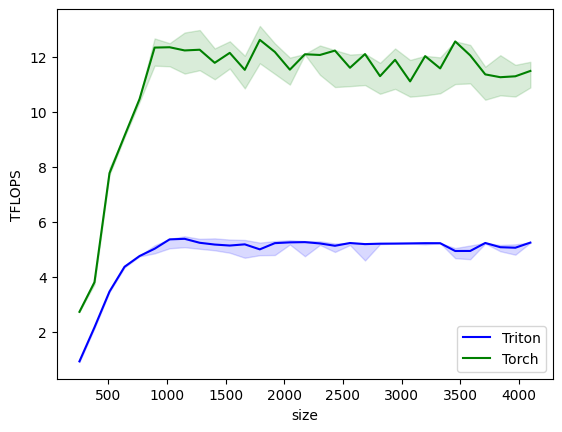

naive-triton-matmul-perf:
      size    Triton      Torch
0    256.0  0.932897   2.730667
1    384.0  2.168471   3.805316
2    512.0  3.467800   7.767230
3    640.0  4.366738   9.122494
4    768.0  4.756645  10.458645
5    896.0  5.021523  12.323930
6   1024.0  5.361418  12.336188
7   1152.0  5.381666  12.220424
8   1280.0  5.237852  12.246286
9   1408.0  5.173460  11.771319
10  1536.0  5.137397  12.132656
11  1664.0  5.180954  11.516304
12  1792.0  4.999188  12.605109
13  1920.0  5.224675  12.166671
14  2048.0  5.252729  11.522813
15  2176.0  5.261493  12.081740
16  2304.0  5.213861  12.055924
17  2432.0  5.129257  12.214984
18  2560.0  5.229492  11.591919
19  2688.0  5.189911  12.088291
20  2816.0  5.205093  11.286499
21  2944.0  5.209126  11.880396
22  3072.0  5.215632  11.096925
23  3200.0  5.223390  12.014408
24  3328.0  5.222893  11.568177
25  3456.0  4.939730  12.547616
26  3584.0  4.941221  12.040115
27  3712.0  5.231340  11.350923
28  3840.0  5.077041  11.248670
29  3968.0  5.

In [5]:
benchmark.run(show_plots=True, print_data=True)

In [6]:
torch.cuda.empty_cache()